# 使用 CUDA 和 NVDEC 的加速视频解码

TorchCodec 可以利用受支持的 Nvidia 硬件（支持矩阵见 [这里](https://developer.nvidia.com/video-encode-and-decode-gpu-support-matrix-new)）加速视频解码。这被称为“CUDA 解码”，它分别使用 Nvidia 的 [NVDEC 硬件解码器](https://developer.nvidia.com/video-codec-sdk) 和 CUDA 内核来完成压缩数据的解码与到 RGB 的转换。

与 CPU 解码相比，CUDA 解码在实际解码阶段以及后续的变换步骤（如缩放、裁剪或旋转）上都可能更快。这是因为解码后的张量会保留在 GPU 内存中，GPU 在执行这些变换时无需从主内存拉取数据。此外，编码的数据包通常比解码后的帧小得多，因此 CUDA 解码也会使用更少的 PCIe 带宽。

## 何时适合使用 CUDA 解码
- 你要解码高分辨率视频
- 你要以较大批量解码视频并且 CPU 已接近饱和
- 你希望在解码后的张量上进行整图变换（如缩放或卷积）
- 你的 CPU 已经很忙，想把负载转移出去

## 何时不一定需要 CUDA 解码
- 你需要与 CPU 解码结果完全比特级一致
- 视频分辨率较小且 PCIe 传输延迟占比大
- GPU 已经很忙而 CPU 空闲

最好的方式是针对你的场景做一些实验。使用 TorchCodec 时，只需给 `VideoDecoder` 传入一个设备参数即可切换到 CUDA 解码。

## 安装启用 CUDA 的 TorchCodec
安装步骤请参考 [README](https://github.com/pytorch/torchcodec#installing-cuda-enabled-torchcodec)。


In [1]:
import matplotlib.pyplot as plt
from matplotlib import font_manager
import os

def _set_chinese_font():
    candidates = [
        "Microsoft YaHei",
        "Microsoft JhengHei",
        "SimHei",
        "SimSun",
        "Noto Sans CJK SC",
        "Noto Sans CJK JP",
        "Source Han Sans SC",
        "PingFang SC",
        "Arial Unicode MS",
    ]
    available = {f.name for f in font_manager.fontManager.ttflist}
    for name in candidates:
        if name in available:
            plt.rcParams['font.family'] = 'sans-serif'
            plt.rcParams['font.sans-serif'] = [name]
            plt.rcParams['axes.unicode_minus'] = False
            return name
    win_fonts = [
        r"C:\Windows\Fonts\msyh.ttc",
        r"C:\Windows\Fonts\simhei.ttf",
        r"C:\Windows\Fonts\simsun.ttc",
    ]
    for path in win_fonts:
        if os.path.exists(path):
            font_manager.fontManager.addfont(path)
            font_name = font_manager.FontProperties(fname=path).get_name()
            plt.rcParams['font.family'] = 'sans-serif'
            plt.rcParams['font.sans-serif'] = [font_name]
            plt.rcParams['axes.unicode_minus'] = False
            return font_name
    print('Warning: 未找到中文字体，可能出现缺字警告。')
    return None

_chinese_font = _set_chinese_font()
if _chinese_font:
    print(f'已使用中文字体: {_chinese_font}')


已使用中文字体: Microsoft YaHei


## 检查 PyTorch 是否启用 CUDA

注意：本教程需要使用带有 CUDA 支持编译的 FFmpeg 库。


In [2]:
import torch

print(f"{torch.__version__=}")
print(f"{torch.cuda.is_available()=}")
print(f"{torch.cuda.get_device_properties(0)=}")


torch.__version__='2.9.1'
torch.cuda.is_available()=True
torch.cuda.get_device_properties(0)=_CudaDeviceProperties(name='NVIDIA GeForce RTX 5050 Laptop GPU', major=12, minor=0, total_memory=8150MB, multi_processor_count=20, uuid=a90b135c-38a4-1388-1953-0fc41fecf813, pci_bus_id=1, pci_device_id=0, pci_domain_id=0, L2_cache_size=32MB)


## 下载示例视频

我们将使用下面的视频，具有如下属性：
- 编解码器：H.264
- 分辨率：960×540
- 帧率：29.97 FPS
- 像素格式：YUV420P

<video style="max-width: 100%" controls>
  <source src="https://download.pytorch.org/torchaudio/tutorial-assets/stream-api/NASAs_Most_Scientifically_Complex_Space_Observatory_Requires_Precision-MP4_small.mp4" type="video/mp4">
</video>


In [3]:
import urllib.request

video_file = "video.mp4"
urllib.request.urlretrieve(
    "https://download.pytorch.org/torchaudio/tutorial-assets/stream-api/NASAs_Most_Scientifically_Complex_Space_Observatory_Requires_Precision-MP4_small.mp4",
    video_file,
)


('video.mp4', <http.client.HTTPMessage at 0x28c6486a490>)

## 使用 VideoDecoder 进行 CUDA 解码

要使用 CUDA 解码器，需要给解码器传入一个 CUDA 设备。建议使用 BETA 后端（速度更快）。


In [4]:
from torchcodec.decoders import set_cuda_backend, VideoDecoder

with set_cuda_backend("beta"):
    decoder = VideoDecoder(video_file, device="cuda")
frame = decoder[0]


解码得到的帧以 NCHW 格式返回，并保留在 GPU 显存中。下面查看其形状、数据类型与所在设备。


In [5]:
print(frame.shape, frame.dtype)
print(frame.data.device)


torch.Size([3, 540, 960]) torch.uint8
cuda:0


## 可视化帧并与 CPU 解码结果对比

我们选取若干时间戳，分别用 CPU 与 CUDA 解码器取帧并进行对比。


In [6]:
timestamps = [12, 19, 45, 131, 180]
cpu_decoder = VideoDecoder(video_file, device="cpu")
with set_cuda_backend("beta"):
    cuda_decoder = VideoDecoder(video_file, device="cuda")
cpu_frames = cpu_decoder.get_frames_played_at(timestamps).data
cuda_frames = cuda_decoder.get_frames_played_at(timestamps).data


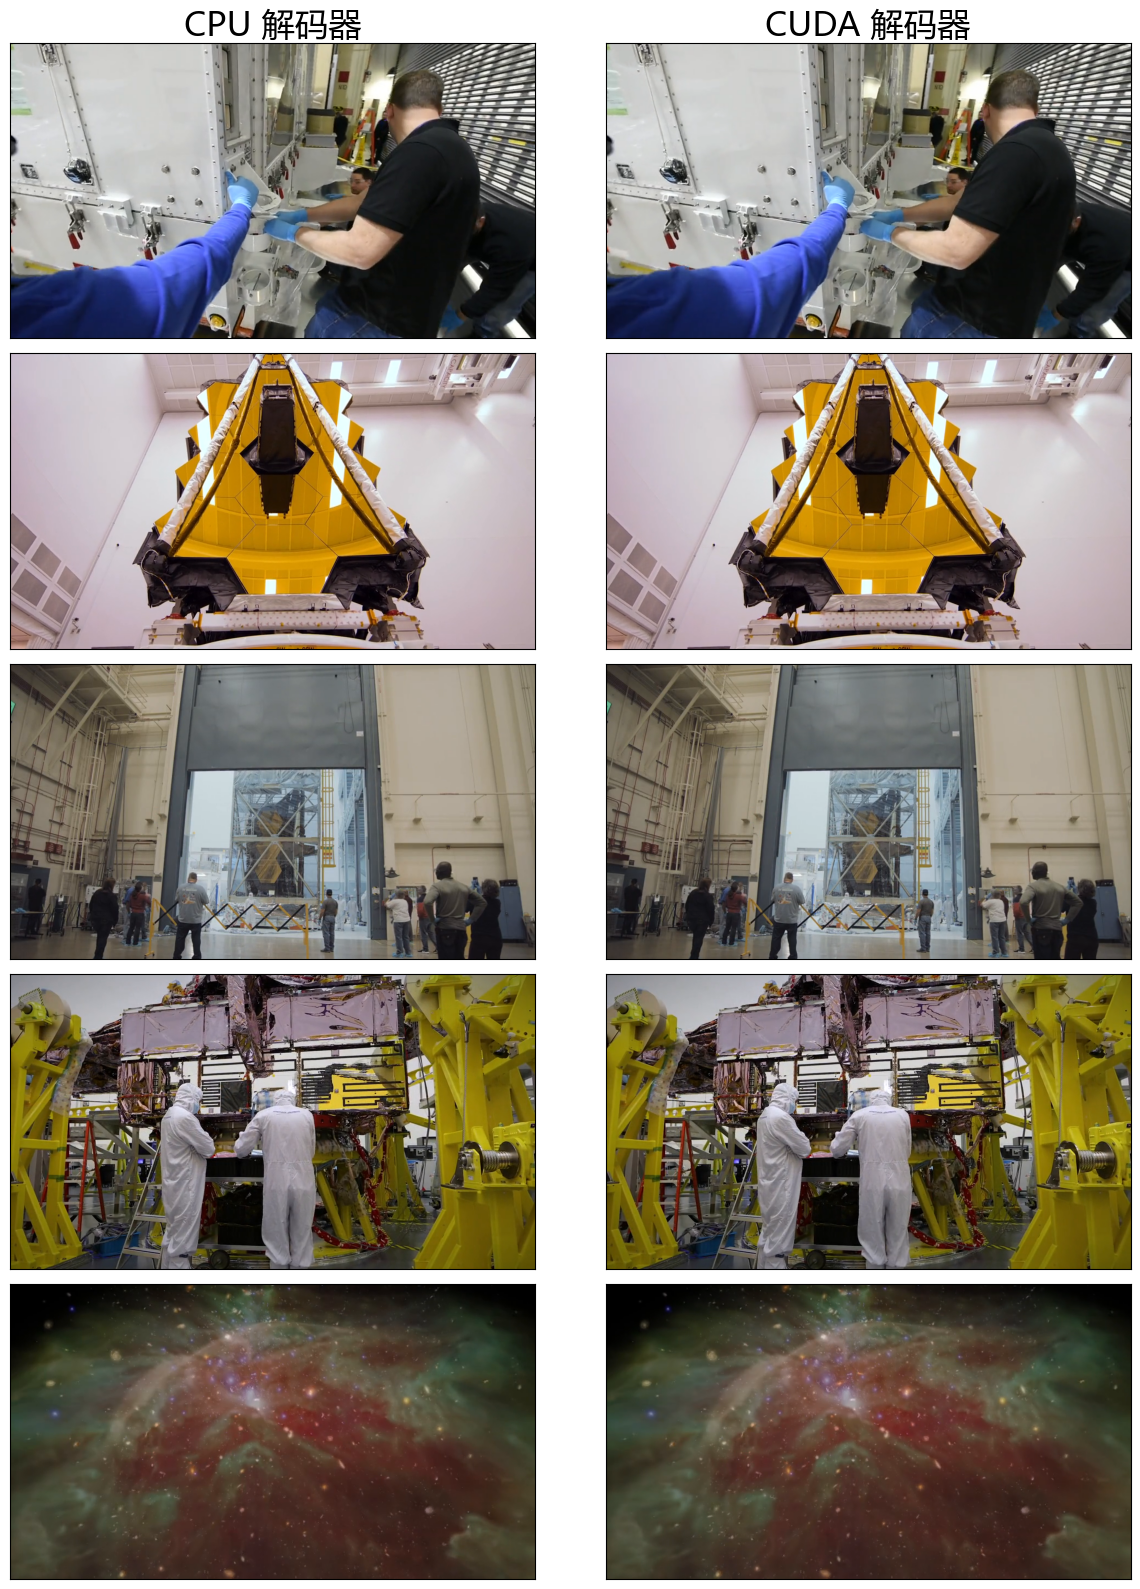

In [7]:
def plot_cpu_and_cuda_frames(cpu_frames: torch.Tensor, cuda_frames: torch.Tensor):
    try:
        import matplotlib.pyplot as plt
        from torchvision.transforms.v2.functional import to_pil_image
    except ImportError:
        print("无法绘制，请运行 `pip install torchvision matplotlib`")
        return
    n_rows = len(timestamps)
    fig, axes = plt.subplots(n_rows, 2, figsize=[12.8, 16.0])
    for i in range(n_rows):
        axes[i][0].imshow(to_pil_image(cpu_frames[i].to("cpu")))
        axes[i][1].imshow(to_pil_image(cuda_frames[i].to("cpu")))

    axes[0][0].set_title("CPU 解码器", fontsize=24)
    axes[0][1].set_title("CUDA 解码器", fontsize=24)
    plt.setp(axes, xticks=[], yticks=[])
    plt.tight_layout()

plot_cpu_and_cuda_frames(cpu_frames, cuda_frames)


从视觉上看它们非常相似，但由于 CUDA 与 CPU 的数学实现并非比特级完全一致，数值上可能存在非常细微的差异。下面计算一些简单的指标。


In [8]:
frames_equal = torch.equal(cpu_frames.to("cuda"), cuda_frames)
mean_abs_diff = torch.mean(
    torch.abs(cpu_frames.float().to("cuda") - cuda_frames.float())
)
max_abs_diff = torch.max(torch.abs(cpu_frames.to("cuda").float() - cuda_frames.float()))
print(f"{frames_equal=}")
print(f"{mean_abs_diff=}")
print(f"{max_abs_diff=}")


frames_equal=False
mean_abs_diff=tensor(0.5636, device='cuda:0')
max_abs_diff=tensor(2., device='cuda:0')
